In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn

## Import des données

In [11]:
us_equity = pd.read_csv('/Users/badremhiouah/Desktop/3A SM10/Physique des marchés/données/daily/us_equities_logreturns.csv.gz')
T = 50 # N/3
N = 1000
us_equity_window = us_equity.iloc[:T,:N]
us_equity_window.dropna(axis=1, inplace=True)
us_equity_window.shape

(50, 952)

## Code de l'agorithme de Louvain (fourni)

In [19]:
from numpy import linalg as LA
import numpy as np
import pandas as pd
import math
import networkx as nx
import community.community_louvain as community_louvain   # pip install python-louvain


def compute_C_minus_C0(lambdas,v,lambda_plus):
    N=len(lambdas)
    C_clean=np.zeros((N, N))
    
    v_m=np.matrix(v)

    for i in range(N):
        if lambdas[i]>lambda_plus:
            C_clean=C_clean+lambdas[i] * np.dot(v_m[:,i],v_m[:,i].T)  
    return C_clean    
    
    
def LouvainCorrelationClustering(R):   # R is a matrix of return
    N=R.shape[1]
    T=R.shape[0]

    q=N*1./T
    lambda_plus=(1.+np.sqrt(q))**2

    C=R.corr()
    lambdas, v = LA.eigh(C)
    
    C_s=compute_C_minus_C0(lambdas,v,lambda_plus)
    C_s=np.abs(C_s)
    
    mygraph= nx.from_numpy_array(np.abs(C_s)) #modif
    partition = community_louvain.best_partition(mygraph)

    DF=pd.DataFrame.from_dict(partition,orient="index")
    return(DF)

In [20]:
mu = LouvainCorrelationClustering(us_equity_window)
print(mu.shape)
print(mu[0].unique())

(952, 1)
[1 2 0]


On a ainsi construit $\mu_t$ qui a $t$ associe un état pour chaque titre, en se basant sur les $T$ derniers jours. Dans cet exemple préliminaire, il y a 3 états possibles.

## Nombre d'états en fonction du temps

In [21]:
def sliding_window():
    t, nb_state = 100+np.array(range(T)), np.array(range(T))
    for ti in range(T):
        T_start = ti
        T_end = ti+100
        us_equity_window = us_equity.iloc[T_start:T_end,:].copy()
        us_equity_window.dropna(axis=1,inplace=True)
        mu = LouvainCorrelationClustering(us_equity_window)
        nb_state[ti] = len(mu[0].unique())
    return t, nb_state

t, nb_state = sliding_window()

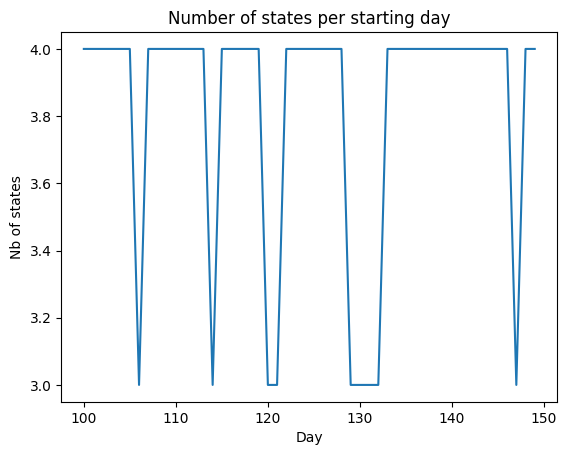

In [22]:
plt.plot(t, nb_state)
plt.title('Number of states per starting day')
plt.xlabel('Day')
plt.ylabel('Nb of states')
plt.show()

Etats entre 3 et 4

## Question 3


In [27]:
T_begin = 2000
def sliding_window(T_begin, T = 40):
    t = np.array(range(T))
    states = pd.DataFrame()
    for ti in range(T):
        T_start = T_begin+ti
        us_equity_window = us_equity.iloc[T_start:T_start+T,:].copy()
        us_equity_window.dropna(axis=1,inplace=True)
        states[f'{ti}'] = LouvainCorrelationClustering(us_equity_window)[0]
    return t, states

In [28]:
t, states= sliding_window(T_begin)
states

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
0,0,0,2,2,2,0,1,1,2,1,...,0,0,2,2,2,0,2,1,1,0
1,0,0,2,2,2,0,1,1,2,1,...,0,0,2,2,2,0,2,1,1,0
2,0,0,2,2,2,0,1,1,2,1,...,2,2,1,1,2,0,0,1,0,2
3,0,0,2,2,2,0,1,1,2,1,...,0,0,2,0,1,0,0,2,0,2
4,0,0,2,2,2,0,1,1,2,1,...,0,0,2,2,2,1,1,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
977,0,0,2,2,2,0,1,2,1,2,...,2,2,1,1,1,1,1,0,0,1
978,0,0,0,1,1,0,0,1,2,1,...,0,0,2,2,2,0,0,1,0,2
979,0,0,2,2,2,0,1,0,0,0,...,2,2,1,1,1,1,2,1,1,0
980,0,0,2,2,2,0,1,1,2,1,...,0,0,2,2,2,0,2,1,1,0


La première ligne de cette matrice correspond aux états de l'index du S&P 500 pour $50$ dates.

In [25]:
mu_SP = states.iloc[0]

In [26]:
# Construisons la matrice P
K = int(0.8*T)
P = np.zeros((T-K, K))

P[0] = mu_SP[:K][::-1]
P[:,0] = mu_SP[K:]

for i in range(1,T-K):
    for j in range(1,K):
        P[i,j] = P[i-1,j-1]

ValueError: could not broadcast input array from shape (20,) into shape (40,)

In [ ]:
# Vecteur de rendements
SP = us_equity['^GSPC'].iloc[1000+K:1000+T]
r = SP.array
sgn_R = np.where(r > 0,1,0)

In [ ]:
# Nous utilisons un arbre de décision (comme notre variable à prédire est binaire)

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

X_train, y_train = P[:-1], sgn_R[:-1]
X_test, y_test = P[-1].reshape(1,-1), sgn_R[-1].reshape(1,-1)

model = DecisionTreeClassifier(random_state = 0)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print("Score:", model.score(X_test, y_test))

Score: 1.0


La dernière ligne est correctement prédite. Ainsi, on notera $x_{t+1}$ la prédiction de l'algorithme. En effet, si $x_{t+1} = 1$ alors on prévoit que le rendement $R_{t+1} > 0$, donc on souhaite acheter pour profiter de la hausse du prix. Idem dans le cas contraire.

In [ ]:
def strat_state(strat, length):
    T = 20
    K = int(0.8*T)
    g = np.zeros((100,))
    
    for tau in range(strat, strat+length):
        
        t, states= sliding_window(tau)
        
        mu_SP = states.iloc[0]
        
        def def_matrice(mu_SP):
            P = np.zeros((T-K, K))
            P[0] = mu_SP[:K][::-1]
            P[:,0] = mu_SP[K:]
            for i in range(1,T-K):
                for j in range(1,K):
                    P[i,j] = P[i-1,j-1]
            return P
    
        P = def_matrice(mu_SP)
        
        SP = (us_equity['^GSPC'].iloc[tau+K:tau+T]).array
        sgn_R = np.where(SP > 0, 1, 0)
        
        model = DecisionTreeClassifier(random_state = 0)
        model.fit(P[:-1], sgn_R[:-1])
        
        g[tau - strat] = model.predict(P[-1].reshape(1, -1))*SP[-1]
        
    return g

In [ ]:
g = strat_state(3000, 20)

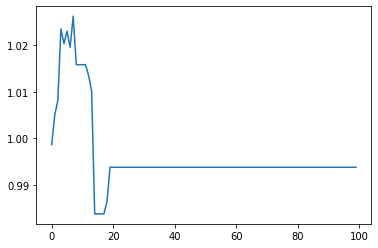

In [ ]:
plt.plot(np.cumprod(1+g))
plt.show()